# <font color='black'>Introduction to Machine Learning</font>

---

## <font color='black'>Contents</font>

---
 
1. [Set-Up](#Set-Up)
2. [Logistic Regression](#LogisticRegression)
 * [Cost function](#GD)
 * [Optimization with the help of a library](#Optim)
3. [Regularized Logistic Regression](#LogisticRegression)
 * [Feature Mapping](#FeatureMapping)
 * [Regularized Cost function](#FeatureScaling)


The objective of this notebook is to code logistic regression.


## <font color='black'>Set-Up</font>

---

First we will import the packages that we will need throughout the notebook.

In [1]:
# Display plots in this notebook.
%matplotlib inline

# Import the numpy package with the alias np.
import numpy as np           

# Optimization module in scipy
from scipy import optimize

# library written for this exercise 
import utils

import matplotlib.pyplot as plt  
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = (4, 4)
import os

## <font color='black'>Logistic regression </font>

---

We will build a logistic regression model to evaluate the current state of an aircraft component based on the available system data (e.g., flight and maintenance data) and to estimate the future performance and the remaining useful life of the components. 

From the classification results a degradation index is created to serve as an aid to better plan the aircraft maintenance. Data and maintenance logs were used to generate the training dataset that you can use as a training set for logistic regression. 

For each training example, you have the maintenance score and the number of valve replacements.

Our task is to build a classification model that estimates the degradation index based these two values.

In [2]:
# ======================= Load the data=======================
data = np.loadtxt(os.path.join('data', 'data1.txt'), delimiter=',')
X, y = data[:, 0:2], data[:, 2]

We first plot the data in order to get familiar with it.

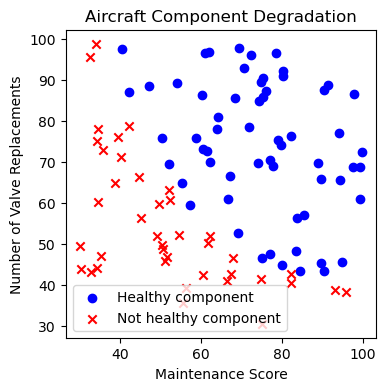

In [3]:
# Define feature names
feature_names = ['Maintenance Score', 'Number of Valve Replacements']

def plotData(X, y):
    plt.figure()
    
    # Separate data points into two classes based on y values (0 or 1)
    positive = y == 1
    negative = y == 0
    
    # Create scatter plots for both classes
    plt.scatter(X[positive, 0], X[positive, 1], marker='o', c='b', label='Healthy component')
    plt.scatter(X[negative, 0], X[negative, 1], marker='x', c='r', label='Not healthy component')
    
    # Label the axes with feature names
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    
    # Add a legend
    plt.legend(loc='best')

    # Show the plot
    plt.title('Aircraft Component Degradation')
    
    
plt.show(plotData(X, y))  

As we know the sigmoid function can take values in the range [0,1]. So large positive values of X will lead to the sigmoid close to 1, while for large negative values, the sigmoid should be close to 0. The sigmoid function is defined as:

$$
g(z) = \cfrac{1}{1 + e^{-z}}
$$

Lets implement this function in the cell below so it can be called by the rest of the practical.

In [4]:
def sigmoid(z):
    z = np.array(z)
    g = 1 / (1 + np.exp(-z))
    return g

The following cell evaluates the sigmoid function at `z=0`. We should get a value of 0.5. We can also try different values for `z` to experiment with the sigmoid function.

In [5]:
# Test the implementation of sigmoid function here
z = 0
g = sigmoid(z)

print('g(', z, ') = ', g)

g( 0 ) =  0.5


### <font color='black'> Cost function and gradient </font>

In [6]:
# Setup the data matrix appropriately, and add ones for the intercept term
m, n = X.shape

# Add intercept term to X
X = np.concatenate([np.ones((m, 1)), X], axis=1)

In this part, we will implement the cost function and gradient for logistic regression. 
The cost function in logistic regression is
$$
J(\theta) = \cfrac{1}{m}\sum_{i = 1}^m [ - y ^{(i)} \log (h_{\theta}(x^{(i)})) - (1 - y ^{(i)}) \log (1 - h_{\theta}(x^{(i)})) ]
$$
and the gradient :

$$
\cfrac{\partial J(\theta)}{\partial\theta_j}  = \cfrac{1}{m}\sum_{i = 1}^m (h_{\theta}(x^{(i)}) -  y ^{(i)}) x^{(i)}
$$

Note that while this gradient looks identical to the linear regression gradient, the formula is actually different because linear and logistic regression have different definitions of $h_\theta(x)$.

In [7]:

def costFunction(theta, X, y):
    # Initialize some useful values
    m = y.size  # number of training examples

    # Initialize cost and gradient
    J = 0
    grad = np.zeros(theta.shape)

    # Calculate the hypothesis (predicted values) for logistic regression
    h = sigmoid(np.dot(X, theta))

    # Calculate the cost J(theta)
    J = (1 / m) * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h))

    # Calculate the gradient
    grad = (1 / m) * np.dot(X.T, (h - y))

    return J, grad

Once you are done call your `costFunction` using two test cases for  $\theta$ by executing the next cell.

In [8]:
# Initialize fitting parameters
initial_theta = np.zeros(n+1)
cost, grad = costFunction(initial_theta, X, y)

print('Cost at initial theta (zeros): {:.3f}'.format(cost))
print('Expected cost (approx): 0.693\n')

print('Gradient at initial theta (zeros):')
print('\t[{:.4f}, {:.4f}, {:.4f}]'.format(*grad))
print('Expected gradients (approx):\n\t[-0.1000, -12.0092, -11.2628]\n')

test_theta = np.array([-24, 0.2, 0.2])
cost, grad = costFunction(test_theta, X, y)

print('Cost at test theta: {:.3f}'.format(cost))
print('Expected cost (approx): 0.218\n')

print('Gradient at test theta:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*grad))
print('Expected gradients (approx):\n\t[0.043, 2.566, 2.647]')

Cost at initial theta (zeros): 0.693
Expected cost (approx): 0.693

Gradient at initial theta (zeros):
	[-0.1000, -12.0092, -11.2628]
Expected gradients (approx):
	[-0.1000, -12.0092, -11.2628]

Cost at test theta: 0.218
Expected cost (approx): 0.218

Gradient at test theta:
	[0.043, 2.566, 2.647]
Expected gradients (approx):
	[0.043, 2.566, 2.647]


### Learning parameters easily using `scipy.optimize`

Up until now, we found the optimal parameters of a linear and logistic regression by implementing gradient descent. 

We wrote a cost function and calculated its gradient, then took a gradient descent step accordingly. 

This time, instead of taking gradient descent steps, we will use the [`scipy.optimize` module](https://docs.scipy.org/doc/scipy/reference/optimize.html). SciPy is a `python` library for numerical computing. It provides an optimization module for minimization. The function `scipy.optimize.minimize` is the method to use for optimization problems(both constrained and unconstrained).

If we have completed the `costFunction` correctly, `optimize.minimize` will converge on the right optimization parameters and return the final values of the cost and $\theta$. Notice we only needed to provide a function calculating the cost and the gradient.

In the following, we can learn how to call the `optimize.minimize` method with the correct arguments.

In [9]:
# set options for optimize.minimize
options= {'maxiter': 400}

res = optimize.minimize(costFunction,initial_theta,(X, y),jac=True,method='TNC',options=options)

# the fun property of `OptimizeResult` object returns
# the value of costFunction at optimized theta
cost = res.fun

# the optimized theta is in the x property
theta = res.x

# Print theta to screen
print('Cost at theta found by optimize.minimize: {:.3f}'.format(cost))
print('Expected cost (approx): 0.203\n')

print('theta:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*theta))
print('Expected theta (approx):\n\t[-25.161, 0.206, 0.201]')

Cost at theta found by optimize.minimize: 0.203
Expected cost (approx): 0.203

theta:
	[-25.161, 0.206, 0.201]
Expected theta (approx):
	[-25.161, 0.206, 0.201]


C:\Users\barth\AppData\Local\Temp\ipykernel_4728\1754441908.py:4: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  res = optimize.minimize(costFunction,initial_theta,(X, y),jac=True,method='TNC',options=options)


Once `optimize.minimize` completes, we want to use the final value for $\theta$ to visualize the decision boundary on the training data
To do so, call `plotDecisionBoundary` for plotting the decision boundary on top of training data. 

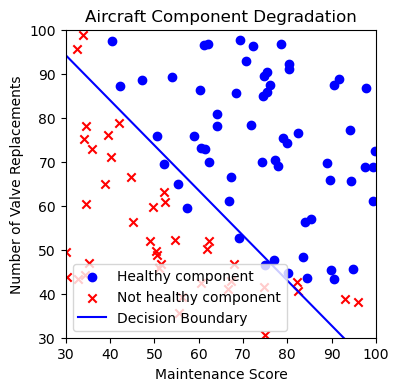

In [10]:
# Plot Boundary
utils.plotDecisionBoundary(plotData, theta, X, y)

### Evaluate the model

After learning the parameters, we can use the model to predict whether a particular component is healthy or needs to be replaced. The predict function will produce “1” or “0” predictions given a dataset and a learned parameter vector $\theta$. 

In [11]:

def predict(theta, X):
    m = X.shape[0]  # Number of training examples

    # Initialize the predictions vector
    p = np.zeros(m)

    # Calculate the probabilities of the positive class (class 1)
    probabilities = sigmoid(np.dot(X, theta))

    # Threshold the probabilities to make binary predictions (0 or 1)
    p = (probabilities >= 0.5).astype(int)

    return p

We now proceed to report the training accuracy of our classifier by computing the percentage of examples it got correct.

In [12]:
#  Predict the degradation index for a component with score maintenace 45 
#  and 85 valve replacements
prob = sigmoid(np.dot([1, 45, 85], theta))
print('For a component with maintenance scores of 45 and 85, '
      'we predict a degradation index of {:.3f}'.format(prob))
print('Expected value: 0.775 +/- 0.002\n')

# Compute accuracy on our training set
p = predict(theta, X)
print('Train Accuracy: {:.2f} %'.format(np.mean(p == y) * 100))
print('Expected accuracy (approx): 89.00 %')

For a component with maintenance scores of 45 and 85, we predict a degradation index of 0.776
Expected value: 0.775 +/- 0.002

Train Accuracy: 89.00 %
Expected accuracy (approx): 89.00 %


## Regularized logistic regression

In this part of the exercise, we will implement regularized logistic regression.
First, we load the data from a CSV file:

In [13]:
# Load Data
# The first two columns contains the X values and the third column
# contains the label (y).
data = np.loadtxt(os.path.join('data', 'data2.txt'), delimiter=',')
X = data[:, :2]
y = data[:, 2]

### Visualize the data

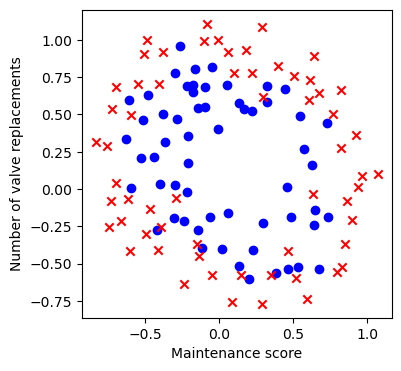

In [14]:
pos = np.where(y == 1)
neg = np.where(y == 0)
plt.scatter(X[pos, 0], X[pos, 1], marker='o', c='b', label='Healthy component')
plt.scatter(X[neg, 0], X[neg, 1], marker='x', c='r', label='Not healthy component')
plt.xlabel('Maintenance score')
plt.ylabel('Number of valve replacements')
plt.show()

The above figure shows that the dataset cannot be separated into positive and negative examples by a straight-line. Therefore, a straight-forward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.

### Feature mapping

One can create more features from each data point. The function `mapFeature` defined in the file `utils.py`, will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.

$$ \text{mapFeature}(x) = \begin{bmatrix} 1 & x_1 & x_2 & x_1^2 & x_1 x_2 & x_2^2 & x_1^3 & \dots & x_1 x_2^5 & x_2^6 \end{bmatrix}^T $$

As a result of this mapping, our vector of two features has been transformed into a \bf{28-dimensional} vector. A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot.


While the feature mapping allows us to build a more expressive classifier, it also more susceptible to overfitting. In the next parts of the exercise, you will implement regularized logistic regression to fit the data and also see for yourself how regularization can help combat the overfitting problem.

In [15]:
# The mapFeature also adds a column of ones for us, so the intercept term is handled
X = utils.mapFeature(X[:, 0], X[:, 1])

###  Cost function and gradient

Now we will implement code to compute the cost function and gradient for regularized logistic regression. Complete the code for the function `costFunctionReg` below to return the cost and gradient.

Recall that the regularized cost function in logistic regression is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)}\log \left( h_\theta \left(x^{(i)} \right) \right) - \left( 1 - y^{(i)} \right) \log \left( 1 - h_\theta \left( x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

Note that we should not regularize the parameters $\theta_0$. The gradient of the cost function is a vector where the $j^{th}$ element is defined as follows:

$$ \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \qquad \text{for } j =0 $$

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m}\theta_j \qquad \text{for } j \ge 1 $$


In [16]:
def costFunctionReg(theta, X, y, lambda_):
    m = y.size  # number of training examples

    # Initialize cost and gradient
    J = 0
    grad = np.zeros(theta.shape)

    # Calculate the hypothesis (predicted values) for logistic regression
    h = sigmoid(np.dot(X, theta))

    # Calculate the cost J(theta) without regularization
    J = (1 / m) * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h))

    # Calculate the regularization term (excluding theta[0])
    reg_term = (lambda_ / (2 * m)) * np.sum(theta[1:] ** 2)

    # Add the regularization term to the cost
    J += reg_term

    # Calculate the gradient (including regularization)
    grad = (1 / m) * np.dot(X.T, (h - y))

    # Calculate the regularization term for gradient (excluding theta[0])
    reg_term_gradient = (lambda_ / m) * theta[1:]

    # Add the regularization term to the gradient (excluding theta[0])
    grad[1:] += reg_term_gradient
    
    return J, grad

Once we are done with the `costFunctionReg`, we call it below using the initial value of $\theta$ (initialized to all zeros), and also another test case where $\theta$ is all ones.

In [17]:
# Initialize fitting parameters
initial_theta = np.zeros(X.shape[1])

# Set regularization parameter lambda to 1
# DO NOT use `lambda` as a variable name in python
# because it is a python keyword
lambda_ = 1

# Compute and display initial cost and gradient for regularized logistic
# regression
cost, grad = costFunctionReg(initial_theta, X, y, lambda_)

print('Cost at initial theta (zeros): {:.3f}'.format(cost))
print('Expected cost (approx)       : 0.693\n')

print('Gradient at initial theta (zeros) - first five values only:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad[:5]))
print('Expected gradients (approx) - first five values only:')
print('\t[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]\n')


# Compute and display cost and gradient
# with all-ones theta and lambda = 10
test_theta = np.ones(X.shape[1])
cost, grad = costFunctionReg(test_theta, X, y, 10)

print('------------------------------\n')
print('Cost at test theta    : {:.2f}'.format(cost))
print('Expected cost (approx): 3.16\n')

print('Gradient at initial theta (zeros) - first five values only:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad[:5]))
print('Expected gradients (approx) - first five values only:')
print('\t[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]')

Cost at initial theta (zeros): 0.693
Expected cost (approx)       : 0.693

Gradient at initial theta (zeros) - first five values only:
	[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]
Expected gradients (approx) - first five values only:
	[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]

------------------------------

Cost at test theta    : 3.16
Expected cost (approx): 3.16

Gradient at initial theta (zeros) - first five values only:
	[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]
Expected gradients (approx) - first five values only:
	[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]


### Regularization

To finish we will try out different regularization parameters for the dataset to visualize how regularization prevents overfitting.

The objective is to observe the changes in the decision boundary as we change the value of $\lambda$. With a small
$\lambda$, we will find that the classifier gets almost every training example correct, but draws a very complicated boundary, thus overfitting the data.

With a larger $\lambda$, we should see a plot that shows an simpler decision boundary which still distinguishes the positives and negatives fairly well. However, if $\lambda$ is set to too high a value, we will not get a good fit and the decision boundary will not follow the data so well, thus underfitting the data.

C:\Users\barth\AppData\Local\Temp\ipykernel_4728\3151805405.py:10: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  res = optimize.minimize(costFunctionReg, initial_theta,(X, y, lambda_),jac=True,method='TNC', options=options)


Train Accuracy: 83.1 %
Expected accuracy (with lambda = 1): 75.4 % (approx)



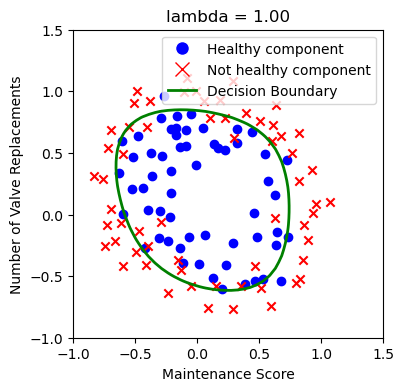

In [18]:
# Initialize fitting parameters
initial_theta = np.zeros(X.shape[1])

# Set regularization parameter lambda to 1 (you should vary this)
lambda_ = 1

# set options for optimize.minimize
options= {'maxiter': 100}

res = optimize.minimize(costFunctionReg, initial_theta,(X, y, lambda_),jac=True,method='TNC', options=options)

# the fun attribute of OptimizeResult object returns the value of costFunction at optimized theta
cost = res.fun

# the optimized theta is in the x attribute of the result
theta = res.x

utils.plotDecisionBoundary(plotData, theta, X, y)
plt.grid(False)
plt.title('lambda = %0.2f' % lambda_)

# Compute accuracy on our training set
p = predict(theta, X)

print('Train Accuracy: %.1f %%' % (np.mean(p == y) * 100))
print('Expected accuracy (with lambda = 1): 75.4 % (approx)\n')